## Working with Sunspots Dataset:

In [1]:
import csv 
import tensorflow as tf 
import pandas as pd 
import warnings 
import numpy as np 
warnings.filterwarnings('ignore')

print(f"Tensorflow Version {tf.__version__}")

Tensorflow Version 2.0.0-dev20191002


In [2]:
timesteps = []
sunspots = []

with open('Sunspots.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    next(reader)
    
    for row in reader:
        sunspots.append((float(row[2])))
        timesteps.append(int(row[0]))

In [3]:
df = pd.read_csv('Sunspots.csv')

df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [10]:
import matplotlib.pyplot as plt 

def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

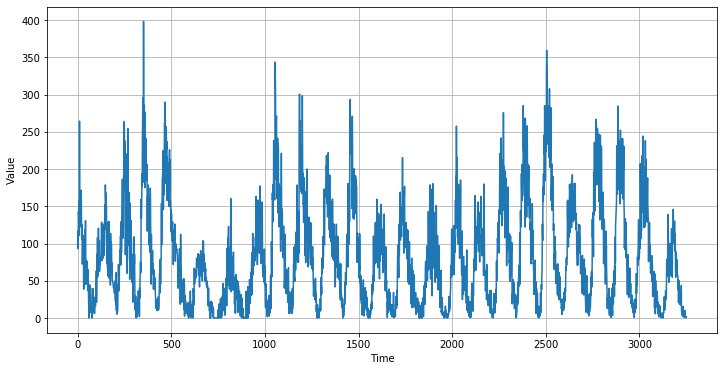

In [11]:
series = np.array(sunspots)
time = np.array(timesteps)

plt.figure(figsize=(12,6))
plot_series(time, series)

## Splitting our Data into Training / Validation sets:

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## Turning a Series into Windowed Dataset for Traning:

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Building our Model:

In [16]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

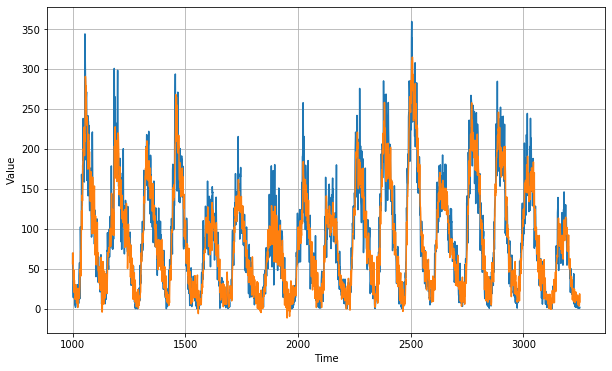

In [17]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

MAE: 20.779337
